For the first step we will import every function needed in our code , we will work basically with Tensorflow Library where we will use it for a simple CNN , then for an Hybrid Model (CNN+RNN) , then for a pre-trained vgg16 model and finally for a ResNet50 pre-trained Model.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Conv1D, Reshape, MaxPooling1D, TimeDistributed, Bidirectional
from keras.layers import Input
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



In [2]:
img_height, img_width = 224, 224
batch_size = 32
data_dir = 'FCGR_Analysiss_k4'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2032 images belonging to 2 classes.
Found 580 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [4]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [5]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
]

history_cnn = cnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 54s 839ms/step - loss: 0.7066 - accuracy: 0.4872 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 49s 761ms/step - loss: 0.6942 - accuracy: 0.4921 - val_loss: 0.6927 - val_accuracy: 0.5103 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 49s 760ms/step - loss: 0.6927 - accuracy: 0.5202 - val_loss: 0.6915 - val_accuracy: 0.5207 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 48s 751ms/step - loss: 0.6912 - accuracy: 0.5325 - val_loss: 0.6900 - val_accuracy: 0.5586 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 46s 718ms/step - loss: 0.6878 - accuracy: 0.5615 - val_loss: 0.6884 - val_accuracy: 0.5172 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 45s 695ms/step - loss: 0.6827 - accuracy: 0.6043 - val_loss: 0.6716 - val_accuracy: 0.6810 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

In [6]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

10/10 [==============================] - 3s 307ms/step - loss: 0.2989 - accuracy: 0.8904
Test Accuracy: 89.04%


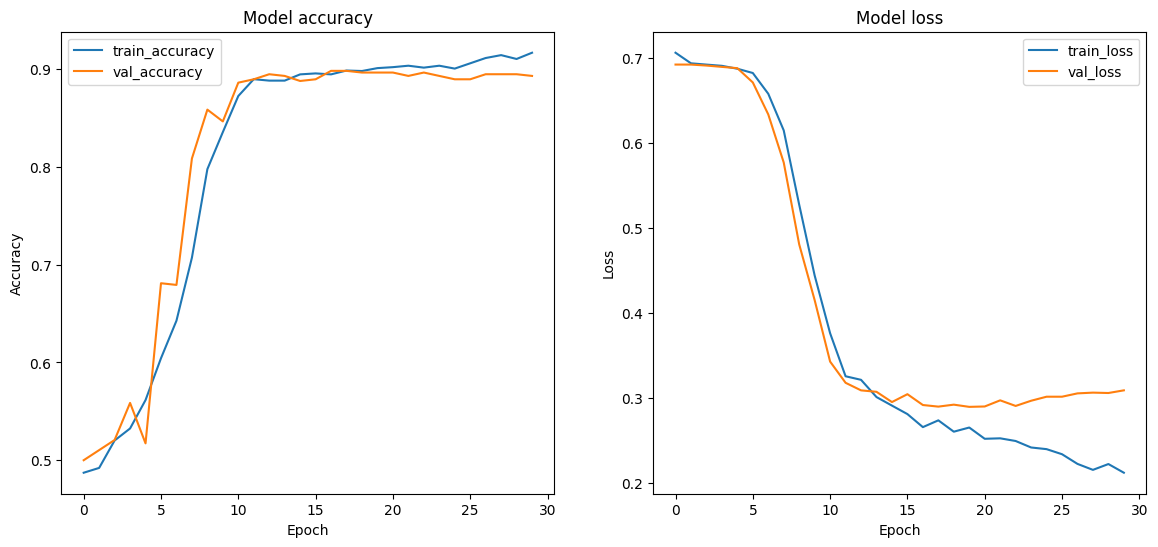

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn.history['loss'], label='train_loss')
ax2.plot(history_cnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 2s 137ms/step
              precision    recall  f1-score   support

           0       0.83      0.99      0.90       146
           1       0.98      0.79      0.88       146

    accuracy                           0.89       292
   macro avg       0.91      0.89      0.89       292
weighted avg       0.91      0.89      0.89       292



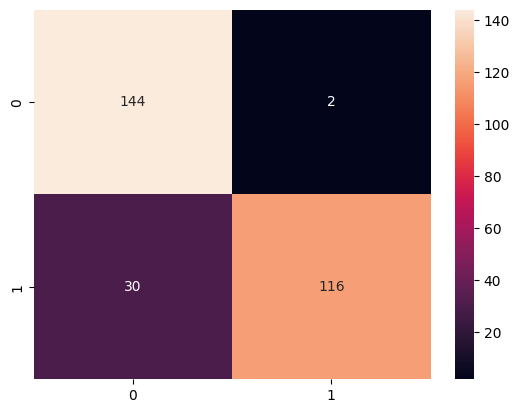

In [8]:
y_pred = cnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

HYbrid Model : 
after the bad results of the Hybrid model in Kmers3 I made the following changes to the original CNN+RNN model code: 
I retained the original CNN layers and ensured they are appropriately defined and connected to the input layer. 
I used a Bidirectional LSTM layer after the CNN layers to better capture sequential dependencies in the data and added a Reshape layer to ensure the data is correctly formatted for the LSTM layer.
Additionally, I set the learning rate for the Adam optimizer to 1e-4 and ensured the data generators are correctly set up with proper data augmentation and preprocessing steps. These changes aim to improve the model's ability to learn from the data and achieve better performance.

In [9]:
input_shape = (img_height, img_width, 3)
input_layer = Input(shape=input_shape)

cnn_layer = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])
cnn_output = cnn_layer(input_layer)
cnn_output = Dense(128, activation='relu')(cnn_output)
cnn_output = Dropout(0.5)(cnn_output)
cnn_output = Reshape((128, 1))(cnn_output)
rnn_layer = Bidirectional(LSTM(64))(cnn_output)
output_layer = Dense(1, activation='sigmoid')(rnn_layer)

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 86528)             93248     
                                                                 
 dense_2 (Dense)             (None, 128)               11075712  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                             

In [10]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_rnn_model.h5', save_best_only=True)
]
history_cnn_rnn = cnn_rnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 53s 791ms/step - loss: 0.6934 - accuracy: 0.4946 - val_loss: 0.6931 - val_accuracy: 0.5086 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 52s 814ms/step - loss: 0.6932 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.5086 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 50s 785ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 0.6930 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 50s 782ms/step - loss: 0.6933 - accuracy: 0.4936 - val_loss: 0.6930 - val_accuracy: 0.5362 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 51s 793ms/step - loss: 0.6930 - accuracy: 0.5010 - val_loss: 0.6928 - val_accuracy: 0.5655 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 51s 797ms/step - loss: 0.6931 - accuracy: 0.5133 - val_loss: 0.6927 - val_accuracy: 0.5448 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

In [11]:
test_loss, test_acc = cnn_rnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


10/10 [==============================] - 2s 163ms/step - loss: 0.2772 - accuracy: 0.8973
Test Accuracy: 89.73%


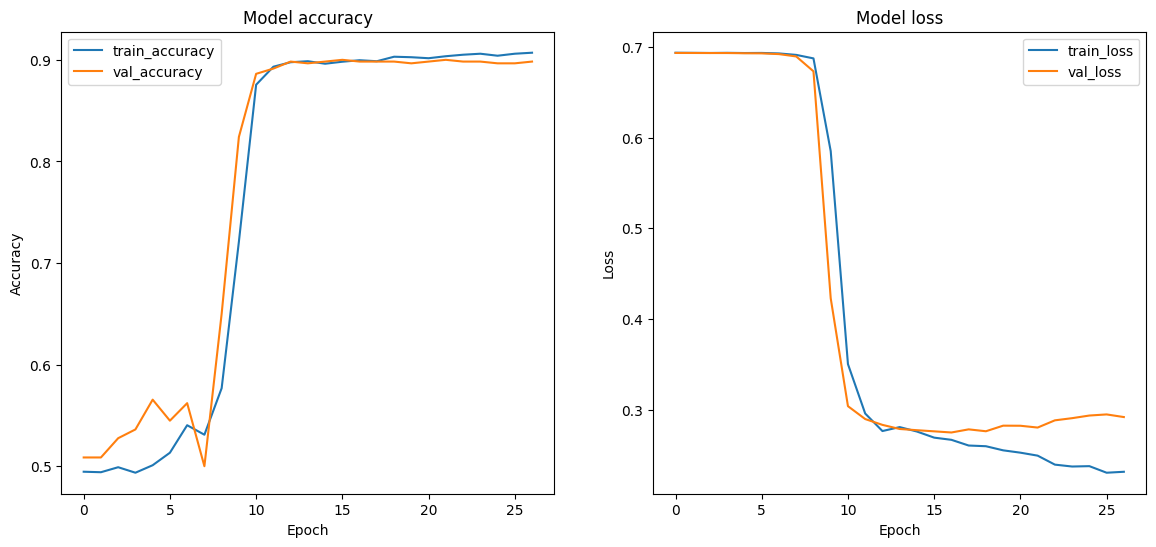

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn_rnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn_rnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn_rnn.history['loss'], label='train_loss')
ax2.plot(history_cnn_rnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 2s 163ms/step
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       146
           1       1.00      0.79      0.89       146

    accuracy                           0.90       292
   macro avg       0.91      0.90      0.90       292
weighted avg       0.91      0.90      0.90       292



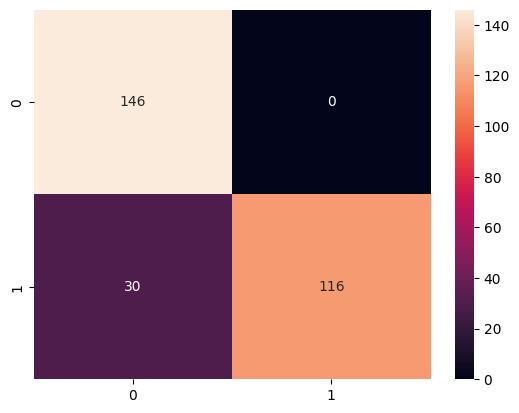

In [13]:
y_pred = cnn_rnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [14]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)
]

history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 183s 3s/step - loss: 0.7526 - accuracy: 0.5172 - val_loss: 0.6806 - val_accuracy: 0.5948 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 182s 3s/step - loss: 0.6925 - accuracy: 0.5276 - val_loss: 0.6794 - val_accuracy: 0.6034 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 177s 3s/step - loss: 0.6899 - accuracy: 0.5354 - val_loss: 0.6752 - val_accuracy: 0.6052 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 179s 3s/step - loss: 0.6750 - accuracy: 0.5738 - val_loss: 0.6624 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 176s 3s/step - loss: 0.6694 - accuracy: 0.5871 - val_loss: 0.6535 - val_accuracy: 0.6983 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 177s 3s/step - loss: 0.6687 - accuracy: 0.5871 - val_loss: 0.6557 - val_accuracy: 0.6379 - lr: 1.0000e-04
Epoch 7/100
64/64 [===========================

In [16]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

10/10 [==============================] - 19s 2s/step - loss: 0.4046 - accuracy: 0.8459
Test Accuracy: 84.59%


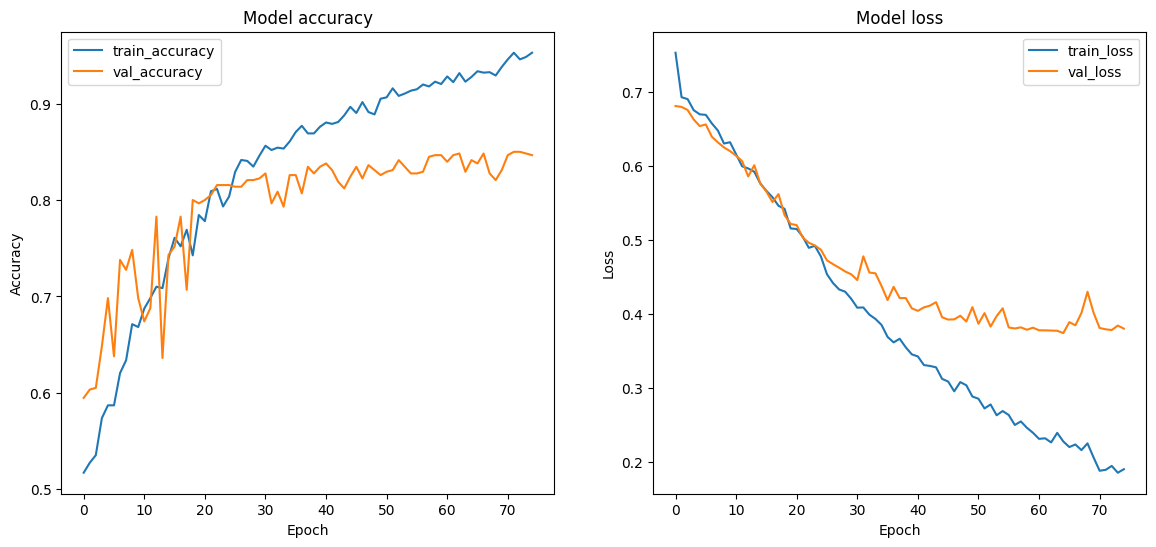

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_vgg16.history['accuracy'], label='train_accuracy')
ax1.plot(history_vgg16.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(history_vgg16.history['loss'], label='train_loss')
ax2.plot(history_vgg16.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()

10/10 [==============================] - 20s 2s/step
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       146
           1       0.89      0.79      0.84       146

    accuracy                           0.85       292
   macro avg       0.85      0.85      0.85       292
weighted avg       0.85      0.85      0.85       292



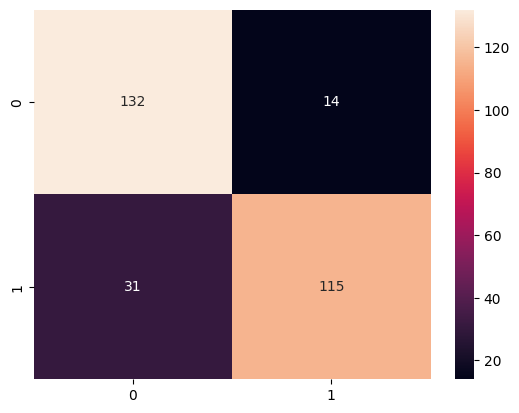

In [18]:
y_pred = vgg16_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [19]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in resnet50_base.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

resnet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_resnet50_model.h5', save_best_only=True)
]

history_resnet50 = resnet50_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/100
64/64 [==============================] - 109s 2s/step - loss: 0.8963 - accuracy: 0.5030 - val_loss: 0.7113 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 101s 2s/step - loss: 0.6967 - accuracy: 0.5044 - val_loss: 0.6930 - val_accuracy: 0.5052 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 100s 2s/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6934 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 100s 2s/step - loss: 0.6937 - accuracy: 0.4823 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 100s 2s/step - loss: 0.6932 - accuracy: 0.4862 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 101s 2s/step - loss: 0.6932 - accuracy: 0.4833 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/100
64/64 [===========================

In [21]:
test_loss, test_acc = resnet50_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


10/10 [==============================] - 16s 2s/step - loss: 0.6930 - accuracy: 0.5171
Test Accuracy: 51.71%


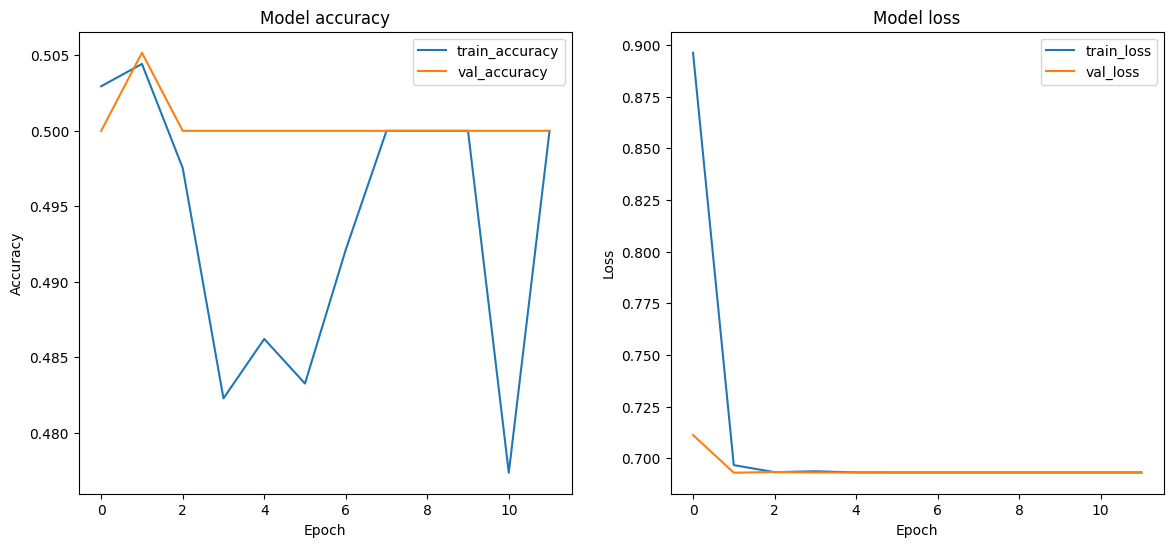

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_resnet50.history['accuracy'], label='train_accuracy')
ax1.plot(history_resnet50.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_resnet50.history['loss'], label='train_loss')
ax2.plot(history_resnet50.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

10/10 [==============================] - 14s 1s/step
              precision    recall  f1-score   support

           0       0.51      0.95      0.66       146
           1       0.62      0.09      0.16       146

    accuracy                           0.52       292
   macro avg       0.56      0.52      0.41       292
weighted avg       0.56      0.52      0.41       292



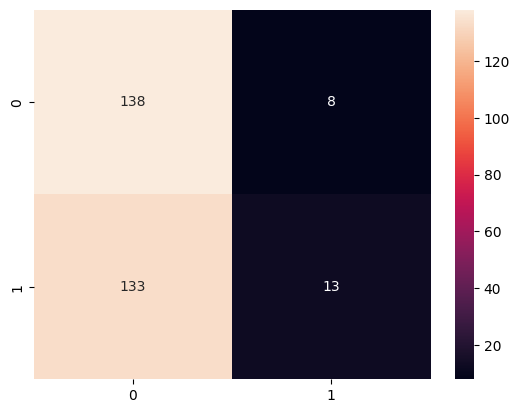

In [23]:
y_pred = resnet50_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()